# Preprocessing Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

In [135]:
if not os.path.isdir("./data"):
  os.mkdir('./data')


data = pd.read_json('./drive/MyDrive/dataset.json')
data.to_csv('./data/data.csv')
data_train,data_test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
data_train.to_csv('./data/data_train.csv', index=False)
data_test.to_csv('./data/data_test.csv', index=False)

## getting data for intent classification
intent_data = data[['question','label']]
intent_train = data_train[['question','label']]
intent_test = data_test[['question','label']]
intent_data.to_csv('./data/intent_data.csv', index=False)
intent_train.to_csv('./data/intent_train.csv', index=False)
intent_test.to_csv('./data/intent_test.csv', index=False)

## getting distinct labels and contexts
labels = data['label'].unique()
contexts = data['context'].unique()

In [32]:
vocab_list = contexts.tolist()
vocab_list += data['question'].tolist()

In [6]:
## finding max length for padding
questions = data['question']
max_len = max(len(s) for s in questions)
print(max_len)

880


In [116]:
train_encoded = pd.get_dummies(intent_train, columns=['label'])
test_encoded = pd.get_dummies(intent_test, columns=['label'])
train_encoded.head()

,question,label_biology,label_chemistry,label_computer,label_mathematics,label_physics
79,What evidence supports the theory of evolution?,1,0,0,0,0
197,"Overall, how would you describe computer science?",0,0,1,0,0
38,What are the key topics explored in physical c...,0,1,0,0,0
24,What is the historical significance of the Ind...,0,0,0,0,1
122,How has the understanding of biomolecules in b...,1,0,0,0,0


In [140]:
X_train = train_encoded["question"].values
Y_train = train_encoded[["label_biology", "label_chemistry", "label_computer", "label_physics", "label_mathematics"]].values
X_test = test_encoded["question"].values
Y_test = test_encoded[["label_biology", "label_chemistry", "label_computer", "label_physics", "label_mathematics"]].values

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((160,), (160, 5), (40,), (40, 5))

# Intent Classifier

In [141]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential,Model,load_model
from keras.layers import Embedding,Dropout,Dense,LSTM

In [142]:
text = vocab_list
Tokenizer = Tokenizer()
Tokenizer.fit_on_texts(text)
Tokenizer_vocab_size = len(Tokenizer.word_index) + 1
Tokenizer_vocab_size

833

In [143]:
X_train, X_val = train_test_split(X_train,test_size=0.2, random_state=42)
Y_train, Y_val = train_test_split(Y_train,test_size=0.2, random_state=42)

X_train_encoded_words = Tokenizer.texts_to_sequences(X_train)
X_val_encoded_words = Tokenizer.texts_to_sequences(X_val)
X_train_encoded_padded_words = sequence.pad_sequences(X_train_encoded_words, maxlen = max_len)
X_val_encoded_padded_words = sequence.pad_sequences(X_val_encoded_words, maxlen = max_len)

X_train_encoded_padded_words.shape, X_val_encoded_padded_words.shape

((128, 880), (32, 880))

In [144]:
model = Sequential()

model.add(Embedding(Tokenizer_vocab_size, 32, input_length=max_len))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 880, 32)           26656     
                                                                 
 lstm_8 (LSTM)               (None, 880, 64)           24832     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 128)               4224      
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 5)                

In [146]:
Nadam = tf.keras.optimizers.Nadam(learning_rate=0.002)
model.compile(loss='categorical_crossentropy', optimizer=Nadam, metrics=['accuracy'])

history  = model.fit(X_train_encoded_padded_words,Y_train, epochs = 8, batch_size=16, validation_data=(X_val_encoded_padded_words, Y_val))

Epoch 1/8
8/8 [==============================] - 16s 728ms/step - loss: 1.2752 - accuracy: 0.4375 - val_loss: 1.3153 - val_accuracy: 0.5938
Epoch 2/8
8/8 [==============================] - 7s 951ms/step - loss: 1.2137 - accuracy: 0.4766 - val_loss: 1.2637 - val_accuracy: 0.4688
Epoch 3/8
8/8 [==============================] - 5s 598ms/step - loss: 1.1317 - accuracy: 0.5234 - val_loss: 1.2429 - val_accuracy: 0.5312
Epoch 4/8
8/8 [==============================] - 5s 581ms/step - loss: 1.0494 - accuracy: 0.4453 - val_loss: 1.1960 - val_accuracy: 0.5312
Epoch 5/8
8/8 [==============================] - 7s 900ms/step - loss: 0.9560 - accuracy: 0.4766 - val_loss: 1.1535 - val_accuracy: 0.5625
Epoch 6/8
8/8 [==============================] - 5s 588ms/step - loss: 0.9950 - accuracy: 0.4844 - val_loss: 1.0988 - val_accuracy: 0.5938
Epoch 7/8
8/8 [==============================] - 5s 677ms/step - loss: 0.9405 - accuracy: 0.5547 - val_loss: 1.0305 - val_accuracy: 0.6250
Epoch 8/8
8/8 [===========

# LSTM Eval

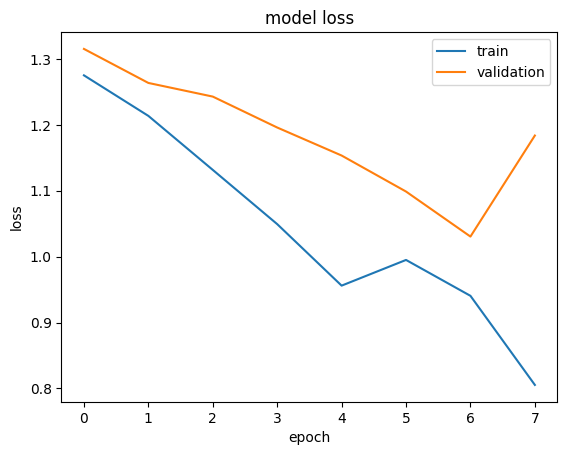

In [149]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

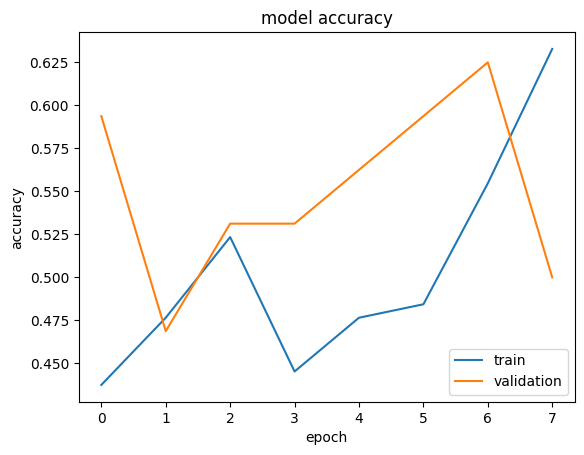

In [148]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [147]:
model.evaluate(X_val_encoded_padded_words, Y_val)

1/1 [==============================] - 2s 2s/step - loss: 1.1838 - accuracy: 0.5000


[1.1838182210922241, 0.5]

In [155]:
X_test_encoded_words = Tokenizer.texts_to_sequences(X_test)
X_test_encoded_padded_words = sequence.pad_sequences(X_test_encoded_words, maxlen = max_len)
evaluation = model.evaluate(X_test_encoded_padded_words, Y_test, verbose=0)
accuracy = evaluation[1]
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 47.50%


In [156]:
model.save("./lstm.keras")

# Custom Intent Prediction

In [150]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

In [152]:
sentence = "What is Quantum Mechnaics?"
tokens = Tokenizer.texts_to_sequences([sentence])
tokens = pad_sequences(tokens, maxlen = max_len)
prediction = model.predict(np.array(tokens))
pred = np.argmax(prediction)
classes = labels
classes[pred]

1/1 [==============================] - 4s 4s/step


'physics'

# Passing the question to BERT

In [ ]:
%%capture
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = tokenizer.encode(sentence, contexts[pred], padding=True,max_length = 1000)

sep_index = input_ids.index(tokenizer.sep_token_id)
num_seg_a = sep_index + 1
num_seg_b = len(input_ids) - num_seg_a
segment_ids = [0]*num_seg_a + [1]*num_seg_b

assert len(segment_ids) == len(input_ids)

outputs = model(torch.tensor([input_ids]),
                             token_type_ids=torch.tensor([segment_ids]),
                             return_dict=True)

start_scores = outputs.start_logits
end_scores = outputs.end_logits

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2632: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [ ]:
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer as tokens: "' + answer + '"')

Answer as tokens: ""
